# This is a generated image based on the GAN architecture with the optimal z-dim selected by the DFO algorithm.

# 1- Dependencies (Required Packages)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision

# 2- Helper Functions

### 2.1- **(inception_score)** This function calculates the Inception Score for a set of images, which is a metric used to evaluate the quality and diversity of generated images.

In [6]:
def inception_score(imgs, model, batch_size=32, splits=10, device='cuda'):
    """
    Calculates the Inception Score for a set of images.

    Args:
        imgs (torch.Tensor): A tensor of images (N, C, H, W).
        model (nn.Module): A pre-trained classifier model (e.g., Inception).
        batch_size (int): Batch size for processing images.
        splits (int): Number of splits for calculating the score.
        device (str): Device to run computations ('cuda' or 'cpu').

    Returns:
        tuple: Mean and standard deviation of the Inception Score.
    """
    model.eval()
    preds = []

    for i in range(0, imgs.shape[0], batch_size):
        batch = imgs[i:i + batch_size].float().to(device)
        # Resize images to 28x28 if necessary
        batch = F.interpolate(batch, size=(28, 28), mode='bilinear', align_corners=False)
        # Ensure batch has shape [batch_size, channels, height, width]
        with torch.no_grad():
            pred = F.softmax(model(batch), dim=1)
            
        preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        py = np.mean(part, axis=0)
        kl = part * (np.log(part) - np.log(py))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

### 2.2- **(show_images)** This function, show_images, is used to display a grid of images in a matplotlib plot.

In [7]:
def show_images(images, num_images=10, cols=5):
    # Display images in a grid
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert from PyTorch tensor to numpy
    fig, axs = plt.subplots(nrows=(num_images // cols), ncols=cols, figsize=(10, 4))
    for i, ax in enumerate(axs.flatten()):
        img = (images[i] + 1) / 2  # Denormalize image to [0, 1] range
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.axis('off')
    plt.show()

### 2.3- **(test_accuracy)**  this function is used to compute accuracy

In [8]:
def test_accuracy(model_classifier, test_loader):
    model_classifier.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_classifier(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

### 2.4- **(set_seed)**  This function, set_seed, is used to set the random seed for reproducibility in a PyTorch and NumPy environment.

In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### 2.5- Data augmentation and normalization for classifier only

In [10]:
# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Changed for grayscale
])

# Train and Test datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders for train and test
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# 3- Classifier for evaluate the z dimension 
This code defines and trains a Convolutional Neural Network (CNN) for classifying MNIST handwritten digits, using PyTorch. The model, MNISTClassifier, consists of two convolutional layers, dropout for regularization, and fully connected layers, trained with the Adam optimizer and a learning rate scheduler.

In [11]:
# Define an enhanced CNN for MNIST classification
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize the model, loss function, and optimizer
model_classifier = MNISTClassifier().to(device)
optimizer = optim.Adam(model_classifier.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Train for more epochs with learning rate scheduler
for epoch in range(5):  # Increased epochs
    model_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_classifier(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")



# Evaluate accuracy on the test dataset
accuracy = test_accuracy(model_classifier, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch 1: Loss = 0.0329
Epoch 2: Loss = 0.0142
Epoch 3: Loss = 0.0796
Epoch 4: Loss = 0.1057
Epoch 5: Loss = 0.0011
Test Accuracy: 98.96%


# 4-  Define and setup the hyperparameters

In [12]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1  # Grayscale for MNIST
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  5- Set the z-dim based on the optimal z-dim after using DFO

In [13]:
# you can test with any number

NOISE_DIM = 5

# 6- Create the Generator and Discriminator (GAN architecture, same architecture used in DFO).

In [14]:

class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img, features_gen):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            self._block(noise_dim, features_gen * 8, 4, 1, 0),
            self._block(features_gen * 8, features_gen * 4, 4, 2, 1),
            self._block(features_gen * 4, features_gen * 2, 4, 2, 1),
            self._block(features_gen * 2, features_gen, 4, 2, 1),
            nn.ConvTranspose2d(features_gen, channels_img, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)

# Create Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_disc):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_disc, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_disc, features_disc * 2, 4, 2, 1),
            self._block(features_disc * 2, features_disc * 4, 4, 2, 1),
            self._block(features_disc * 4, features_disc * 8, 4, 2, 1),
            nn.Conv2d(features_disc * 8, 1, 4, 2, 0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x)

# Weight Initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

# 7- Load the dataset

In [15]:
# Load MNIST dataset
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
mnist = datasets.MNIST(root="dataset/", train=True, transform=data_transform, download=True)
data_loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.63MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# 8- Train the model 

Epoch [0/100] Loss D: 0.7719, Loss G: 1.3224


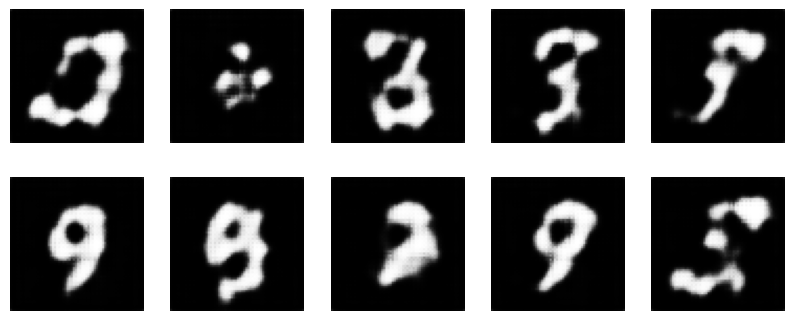

Epoch [1/100] Loss D: 0.5677, Loss G: 1.2581
Epoch [2/100] Loss D: 0.4451, Loss G: 1.1518
Epoch [3/100] Loss D: 0.1848, Loss G: 3.2810
Epoch [4/100] Loss D: 0.1358, Loss G: 2.9126
Epoch [5/100] Loss D: 0.0893, Loss G: 3.2733
Epoch [6/100] Loss D: 0.0998, Loss G: 2.8917
Epoch [7/100] Loss D: 0.0486, Loss G: 3.7970
Epoch [8/100] Loss D: 0.0699, Loss G: 2.6713
Epoch [9/100] Loss D: 0.6462, Loss G: 1.4918
Epoch [10/100] Loss D: 0.0345, Loss G: 3.2905


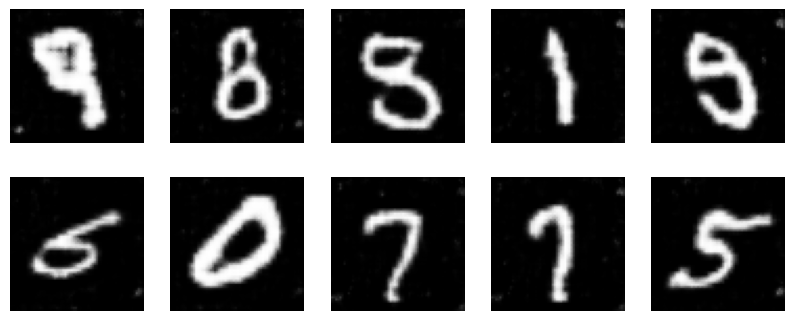

Epoch [11/100] Loss D: 0.1583, Loss G: 3.4924
Epoch [12/100] Loss D: 0.3694, Loss G: 2.0304
Epoch [13/100] Loss D: 0.8554, Loss G: 10.0981
Epoch [14/100] Loss D: 0.2224, Loss G: 3.6610
Epoch [15/100] Loss D: 0.0247, Loss G: 4.6703
Epoch [16/100] Loss D: 0.0239, Loss G: 4.3072
Epoch [17/100] Loss D: 0.0248, Loss G: 4.6258
Epoch [18/100] Loss D: 0.1774, Loss G: 2.4362
Epoch [19/100] Loss D: 0.0366, Loss G: 3.8088
Epoch [20/100] Loss D: 0.0137, Loss G: 4.5478


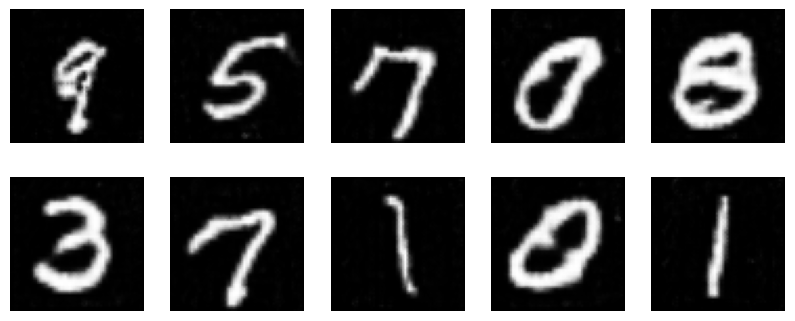

Epoch [21/100] Loss D: 0.0161, Loss G: 5.2458
Epoch [22/100] Loss D: 0.0364, Loss G: 4.0243
Epoch [23/100] Loss D: 0.0307, Loss G: 3.9809
Epoch [24/100] Loss D: 0.1630, Loss G: 3.3574
Epoch [25/100] Loss D: 0.2049, Loss G: 2.3625
Epoch [26/100] Loss D: 0.0299, Loss G: 3.9536
Epoch [27/100] Loss D: 0.0089, Loss G: 5.1086
Epoch [28/100] Loss D: 0.0232, Loss G: 4.8455
Epoch [29/100] Loss D: 0.0380, Loss G: 4.1315
Epoch [30/100] Loss D: 0.0224, Loss G: 5.2941


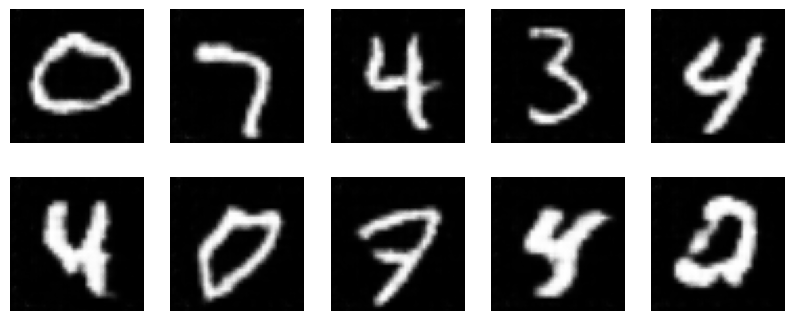

Epoch [31/100] Loss D: 0.2618, Loss G: 3.2206
Epoch [32/100] Loss D: 0.2121, Loss G: 2.6407
Epoch [33/100] Loss D: 0.0077, Loss G: 5.7826
Epoch [34/100] Loss D: 2.5725, Loss G: 3.3685
Epoch [35/100] Loss D: 0.0125, Loss G: 5.3282
Epoch [36/100] Loss D: 0.0219, Loss G: 5.0635
Epoch [37/100] Loss D: 0.0088, Loss G: 6.0383
Epoch [38/100] Loss D: 0.0160, Loss G: 4.8612
Epoch [39/100] Loss D: 0.2550, Loss G: 3.6882
Epoch [40/100] Loss D: 0.0121, Loss G: 5.9706


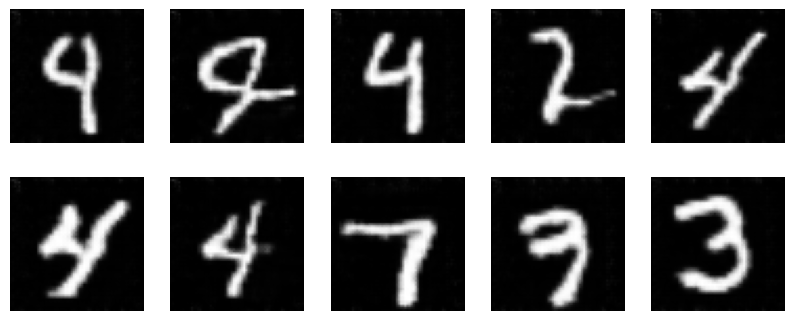

Epoch [41/100] Loss D: 0.0107, Loss G: 5.4821
Epoch [42/100] Loss D: 0.2218, Loss G: 2.3777
Epoch [43/100] Loss D: 0.1115, Loss G: 3.5221
Epoch [44/100] Loss D: 0.0144, Loss G: 5.6942
Epoch [45/100] Loss D: 0.1592, Loss G: 2.3230
Epoch [46/100] Loss D: 0.3646, Loss G: 4.1004
Epoch [47/100] Loss D: 0.0215, Loss G: 4.5038
Epoch [48/100] Loss D: 0.1946, Loss G: 2.1809
Epoch [49/100] Loss D: 0.0673, Loss G: 3.8231
Epoch [50/100] Loss D: 0.2043, Loss G: 2.3496


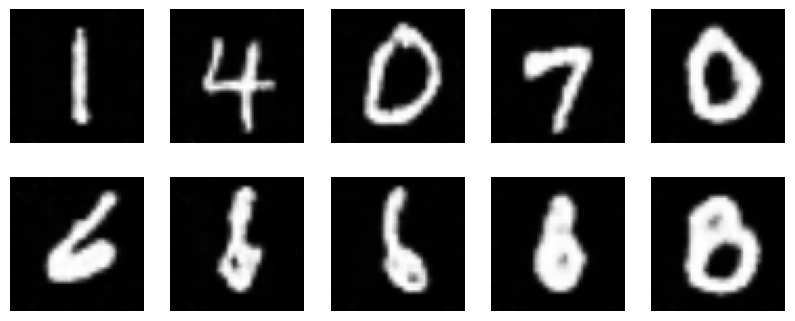

Epoch [51/100] Loss D: 0.0266, Loss G: 4.2562
Epoch [52/100] Loss D: 0.0788, Loss G: 3.3180
Epoch [53/100] Loss D: 0.1825, Loss G: 3.6760
Epoch [54/100] Loss D: 0.0044, Loss G: 6.2679
Epoch [55/100] Loss D: 0.0070, Loss G: 5.5976
Epoch [56/100] Loss D: 0.0068, Loss G: 5.5128
Epoch [57/100] Loss D: 0.0719, Loss G: 3.8308
Epoch [58/100] Loss D: 0.0043, Loss G: 6.3462
Epoch [59/100] Loss D: 0.0022, Loss G: 6.7447
Epoch [60/100] Loss D: 0.1838, Loss G: 3.0495


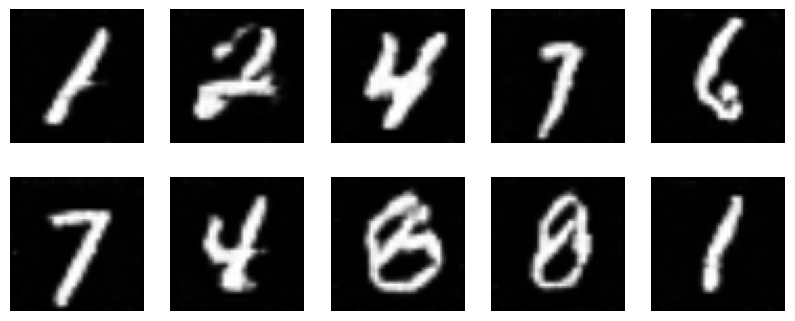

Epoch [61/100] Loss D: 0.0315, Loss G: 4.2890
Epoch [62/100] Loss D: 0.0035, Loss G: 6.1659
Epoch [63/100] Loss D: 0.2285, Loss G: 2.0842
Epoch [64/100] Loss D: 0.0137, Loss G: 5.1734
Epoch [65/100] Loss D: 0.3645, Loss G: 2.1392
Epoch [66/100] Loss D: 0.0124, Loss G: 5.1219
Epoch [67/100] Loss D: 0.0628, Loss G: 3.4195
Epoch [68/100] Loss D: 0.1422, Loss G: 3.0925
Epoch [69/100] Loss D: 0.0056, Loss G: 6.1338
Epoch [70/100] Loss D: 0.0223, Loss G: 4.4811


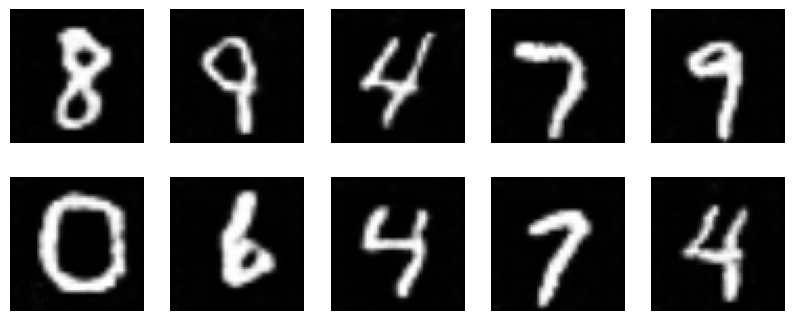

Epoch [71/100] Loss D: 0.0052, Loss G: 6.0961
Epoch [72/100] Loss D: 0.0699, Loss G: 3.3334
Epoch [73/100] Loss D: 0.4991, Loss G: 0.0247
Epoch [74/100] Loss D: 0.1627, Loss G: 2.8898
Epoch [75/100] Loss D: 0.1747, Loss G: 3.3783
Epoch [76/100] Loss D: 0.1845, Loss G: 2.8915
Epoch [77/100] Loss D: 0.0077, Loss G: 5.8222
Epoch [78/100] Loss D: 0.3644, Loss G: 3.9291
Epoch [79/100] Loss D: 0.0027, Loss G: 7.1514
Epoch [80/100] Loss D: 0.0034, Loss G: 5.9264


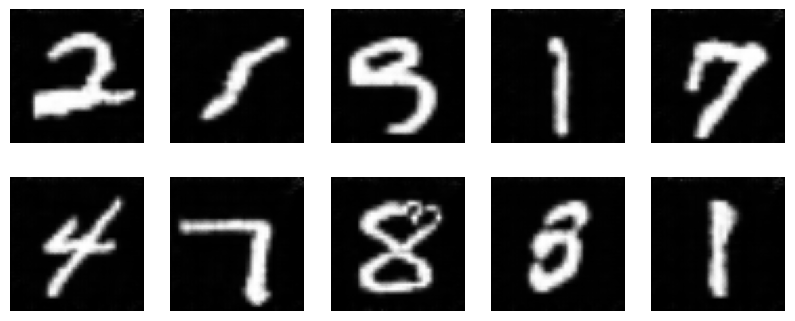

Epoch [81/100] Loss D: 0.0120, Loss G: 6.2100
Epoch [82/100] Loss D: 1.5642, Loss G: 0.4151
Epoch [83/100] Loss D: 0.2008, Loss G: 3.1604
Epoch [84/100] Loss D: 0.0049, Loss G: 6.1641
Epoch [85/100] Loss D: 0.0147, Loss G: 4.8774
Epoch [86/100] Loss D: 0.0974, Loss G: 3.8342
Epoch [87/100] Loss D: 0.0043, Loss G: 5.3401
Epoch [88/100] Loss D: 0.1722, Loss G: 3.1295
Epoch [89/100] Loss D: 0.4116, Loss G: 1.8070
Epoch [90/100] Loss D: 0.1116, Loss G: 2.8589


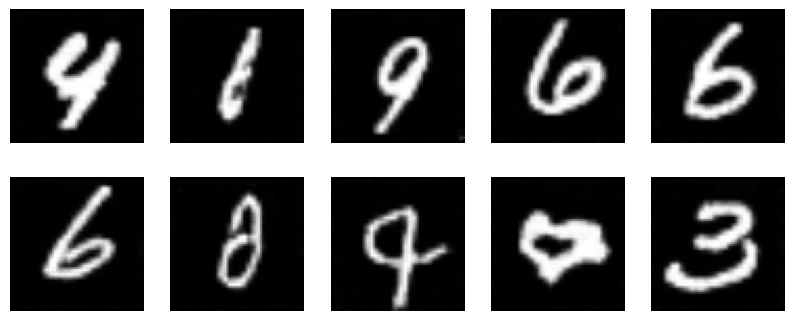

Epoch [91/100] Loss D: 0.0122, Loss G: 5.1937
Epoch [92/100] Loss D: 0.1158, Loss G: 3.4935
Epoch [93/100] Loss D: 0.0124, Loss G: 4.8368
Epoch [94/100] Loss D: 0.1480, Loss G: 2.5585
Epoch [95/100] Loss D: 0.0121, Loss G: 5.6001
Epoch [96/100] Loss D: 0.0097, Loss G: 5.8493
Epoch [97/100] Loss D: 0.1717, Loss G: 3.1328
Epoch [98/100] Loss D: 0.0142, Loss G: 4.9114
Epoch [99/100] Loss D: 0.0011, Loss G: 8.0620


In [16]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(DEVICE)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(DEVICE)
initialize_weights(gen)
initialize_weights(disc)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


ISLIST = []


# Training loop
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(DEVICE)
os.makedirs("generated_images", exist_ok=True)

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(data_loader):
        real = real.to(DEVICE)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(DEVICE)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z))) ###
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))) ###
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

    if epoch % 10 == 0:

        fixed_noise = torch.randn(1000, NOISE_DIM).to(DEVICE).view(1000, NOISE_DIM, 1, 1)
    
        with torch.no_grad():
            fake_images = gen(fixed_noise)  # Generate images using the generator
    
            # Assume 'model' is your pre-trained classifier (e.g., Inception model)
            is_mean, is_std = inception_score(fake_images, model_classifier, device=device)
            ISLIST.append(is_mean)
            
    
            # print(f"Inception Score: {1/is_mean} ± {is_std}, z_dim {z_dim}")
        
        with torch.no_grad():
            fixed_noise = torch.randn(10, NOISE_DIM).to(DEVICE).view(10, NOISE_DIM, 1, 1)
            fake = gen(fixed_noise)
            show_images(fake, num_images=10, cols=5)
            plt.close()

In [ ]:
ISLIST